# Trapped ion pulse sequence simulation

c:\Users\Gonzalo\AppData\Local\Programs\Python\Python312\Lib\site-packages\qutip\solver\solver_base.py:583: FutureWarning: e_ops will be keyword only from qutip 5.3 for all solver
  warnings.warn(


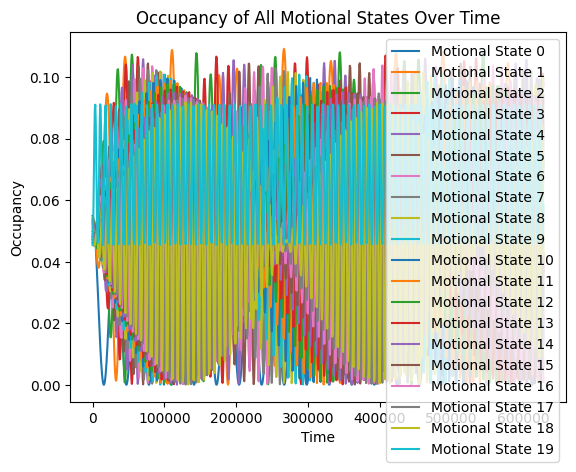

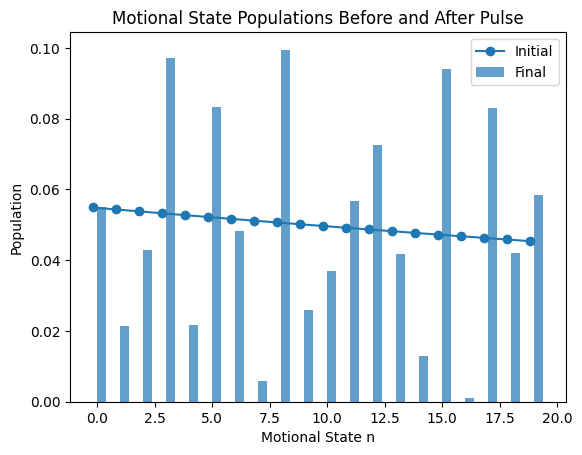

In [108]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import *

# Define system parameters
Delta = 1.0  # Detuning
nu = 1.0     # Motional frequency
Omega=.01  # Rabi frequency
eta = 0.02    # Lamb-Dicke parameter
n_thermal = 1  # Average thermal phonon number
n0 = 1
gamma = 0  # Spin relaxation
beta = 0.01    # Inverse temperature
kT = 1.0      # Boltzmann constant times temperature
tau = 2 * np.pi / (eta * Omega * np.sqrt(n0))  # Pulse duration

# Define operators
N = 20  # Truncation for the Fock space

# QHO operators
a = destroy(N)  # Annihilation operator
a_dag = a.dag()  # Creation operator

# Spin operators
sz = sigmaz()
s_plus = sigmap()
s_minus = sigmam()

# Displacement operator
D_eta = displace(N, (1j * eta)/2)
D_eta_full = tensor(qeye(2), D_eta)

# Full size operators
s_z_full = tensor(sz, qeye(N))
s_plus_full = tensor(s_plus, qeye(N))
a_full = tensor(qeye(2), a)
a_dag_full = tensor(qeye(2), a_dag)
s_minus_full = tensor(s_minus, qeye(N))
s_y_full = tensor(sigmay(), qeye(N))
s_x_full = tensor(sigmax(), qeye(N))

# Original Hamiltonian
# H = Delta/2 * s_z_full + nu * a_dag_full * a_full + Omega/2 * (s_plus_full*D_eta_full + s_minus_full*D_eta_full.dag())

# Red sideband Hamiltonian
H = 1j*eta*Omega/2 * (a_full* s_plus_full - a_dag_full * s_minus_full)

# First apply a displacement operator for i*eta/2
H = D_eta_full * H * D_eta_full.dag()

# Then apply a y pulse of pi/2
H = (1j * np.pi / 4 * s_y_full).expm() * H * (-1j * np.pi / 4 * s_y_full).expm().dag()

# Now apply an x pulse of duration tau
H = (1j * np.pi / 4 * s_x_full).expm() * H * (-1j * np.pi / 4 * s_x_full).expm().dag()

# Undo the y pulse
H = (-1j * np.pi / 4 * s_y_full).expm().dag() * H * (1j * np.pi / 4 * s_y_full).expm()

# Undo the displacement operator
H = D_eta_full.dag() * H * D_eta_full

# Spin relaxation collapse operators
c_ops = []
c_ops.append(np.sqrt(gamma) * s_minus_full)

# Initial state: thermal state for motion and ground state for spin
thermal_state = (-beta * nu * a_dag * a / kT).expm()
thermal_state = thermal_state / thermal_state.tr()  # Normalize
ground_state = basis(2, 1)  # |g>
initial_state = tensor(ground_state * ground_state.dag(), thermal_state)

# Time evolution using Qutip mesolve
T_pulse = 20 * tau # Total time for pulse sequence
times_pulse = np.linspace(0, T_pulse, 1000)
result_pulse = mesolve(H, initial_state, times_pulse, c_ops, [])

# Extract the occupancy of all motional states at all time points
occupancies = np.array([state.ptrace(1).diag().real for state in result_pulse.states])

# Plot the occupancy of all motional states over time
for n in range(N):
    plt.plot(times_pulse, occupancies[:, n], label=f'Motional State {n}')
plt.xlabel('Time')
plt.ylabel('Occupancy')
plt.title('Occupancy of All Motional States Over Time')
plt.legend()
plt.show()

# Bar plot of motional state populations before and after the pulse
p_motional_initial = initial_state.ptrace(1).diag().real
p_motional_final = result_pulse.states[-1].ptrace(1).diag().real
plt.plot(np.arange(N)-0.2, p_motional_initial, 'o-', label='Initial')
plt.bar(np.arange(N)+0.2, p_motional_final, width=0.4, label='Final', alpha=0.7)
plt.xlabel('Motional State n')
plt.ylabel('Population')
plt.title('Motional State Populations Before and After Pulse')
plt.legend()
plt.show()

In [54]:
# Define additional Hamiltonians using qutip
from qutip import tensor, qeye, destroy, sigmaz, sigmax, sigmay, sigmam, basis
import numpy as np
from scipy.linalg import expm

# Define constants and parameters
N = 20  # Truncation for the Fock space
nu = 1.0  # Motional frequency
Delta = 1.0  # Detuning
Omega = 1.0  # Rabi frequency
eta = 0.02  # Lamb-Dicke parameter
gamma = 0.005  # Dissipation rate
G = 1.5 * Omega  # Coupling strength for Lindbladian
tau = np.pi / (eta * Omega * np.sqrt(n0))
tg = 2/G
dt = tau + tg

# Ensure all variables are initialized before constructing Hamiltonians and Lindbladians

# Define identity and operators
Id = qeye(2)  # Identity for spin
Idn = qeye(N)  # Identity for motional states
a = destroy(N)  # Annihilation operator
ad = a.dag()  # Creation operator
n = ad * a  # Number operator
xop = a + ad  # Position operator
sz = sigmaz()
sx = sigmax()
sy = sigmay()
sm = sigmam()

# Define Hamiltonians
H = tensor(nu * n, Id) + tensor(Idn, Delta * sz / 2) + Omega / 2 * (
    tensor((1j * eta * xop).expm(), sm) + tensor((-1j * eta * xop).expm(), sm.dag())
    )

HLD = tensor(nu * n, Id) + tensor(Idn, Delta * sz / 2 + Omega / 2 * sx) + eta * Omega / 2 * tensor(xop, sy)

HJC = tensor(nu * n, Id) + tensor(Idn, Delta * sz / 2 + Omega / 2 * sx) + eta * Omega / 2 * tensor(ad, sm) + eta * Omega / 2 * tensor(a, sm.dag())

H0 = tensor(nu * n, Id) + tensor(Idn, Delta * sz / 2)

# Define Lindblad master equation terms
D = tensor(Idn, sm)
Dt = D.dag()
ID = tensor(Idn, Id)

# Diffusion term of spontaneous emission
carrier = 0
cosmax = 100
cosal = np.arange(-cosmax, cosmax + 1) / cosmax
W = 3 * (cosal**2 + 1) / 4 * 1 / (2 * cosmax)
W = W / sum(W)
for i, c in enumerate(cosal):
    DD = tensor((1j * c * eta * xop).expm(), sm)
    carrier += W[i] * tensor(DD, DD.dag())

# Trapped state Lindbladians
G = 1.5 * Omega
Lc = -1j * tensor(H, ID) + 1j * tensor(ID, H.dag())
Ld = -1j * tensor(H0, ID) + 1j * tensor(ID, H0.dag()) + 2 * G * carrier - G * tensor(Dt * D, ID) - G * tensor(ID, Dt * D)

# Sideband cooling Lindbladian
L = -1j * tensor(H, ID) + 1j * tensor(ID, H.dag()) + 2 * G * carrier - G * tensor(Dt * D, ID) - G * tensor(ID, Dt * D)

# Sideband cooling dynamical map
EL = (-1j * L * dt).expm()
#trapped states dynamical map
ET = ((-1j * Ld * tg).expm()) * ((-1j * Lc * tau).expm())

# Create initial state density matrix rho0
a_dag_full = tensor(ad, qeye(2))
a_full = tensor(a, qeye(2))
thermal_state = (-beta * nu * (ad * a) / kT).expm()
# Normalize
thermal_state = thermal_state / thermal_state.tr()

excited_spin = basis(2, 1) * basis(2, 1).dag()
rho0 = tensor(excited_spin, thermal_state)

ET=np.dot((Ld*tg).expm(),(Lc*tau).expm())

# Create initial state density matrix rho0
thermal_state = (-beta * nu * a_dag_full * a_full / kT).expm()
thermal_state = thermal_state / thermal_state.tr()  # Normalize
# Combine with excite spin state
excited_spin = basis(2, 1) * basis(2, 1).dag()
rho0 = tensor(excited_spin, thermal_state)

# Convert initial density matrix to vector in Liouville space
rho0 = operator_to_vector(rho0)

# Apply EL to rho0 for tsteps
tsteps = 34

for _ in range(tsteps):
    rho0 = EL * rho0  # Apply dynamical map

# Extract final state probabilities
p_g_final = expect(tensor(basis(2, 1) * basis(2, 1).dag(), qeye(N)), rho0)
p_e_final = expect(tensor(basis(2, 0) * basis(2, 0).dag(), qeye(N)), rho0)
p_motional_final = np.zeros(N)
for n in range(N):
    motional_proj = tensor(qeye(2), basis(N, n) * basis(N, n).dag())
    p_motional_final[n] = expect(motional_proj, rho0)

# Plot final motional state probabilities vs initial thermal distribution as bar plot
initial_probs = thermal_state.diag().real
x = np.arange(N)  # Motional state indices
width = 0.35  # Bar width
plt.figure(figsize=(10, 6))
plt.plot(x, initial_probs, 'o-', label='Initial')  # Dots linked by a line
plt.bar(x, p_motional_final, width, label='Final', alpha=0.7)  # Bars for final distribution
plt.xlabel('Motional State (n)')
plt.ylabel('Probability')
plt.title('Initial vs Final Motional State Occupancy after Sideband Cooling')
plt.legend()
plt.grid(axis='y')
plt.show()

TypeError: incompatible dimensions [[20, 2, 20, 2], [20, 2, 20, 2]] and [[[2, 20, 2], [2, 20, 2]], [1]]

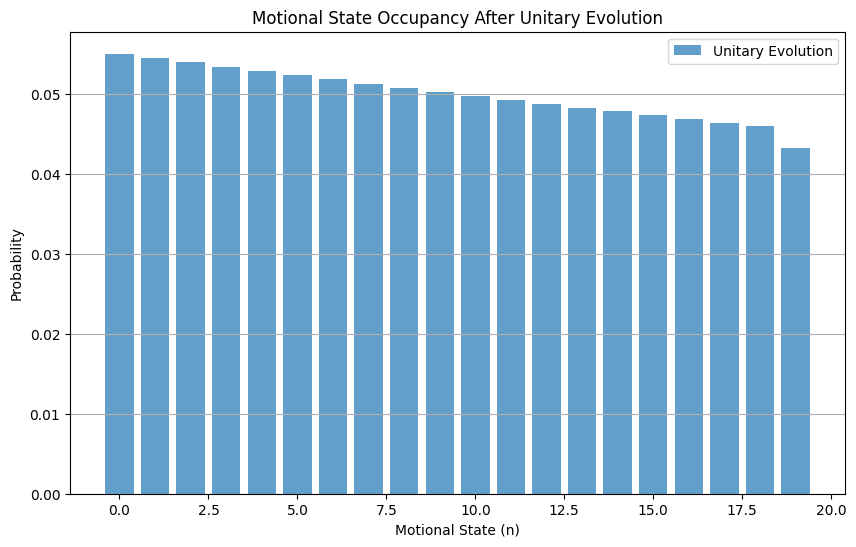

In [66]:
# Time evolution using the unitary operator of the Hamiltonian
U = (-1j * H * T_pulse).expm()  # Unitary operator for time evolution
state_evolved = U * initial_state * U.dag()

# Extract probabilities after unitary evolution
p_g_unitary = expect(tensor(basis(2, 1) * basis(2, 1).dag(), qeye(N)), state_evolved)
p_e_unitary = expect(tensor(basis(2, 0) * basis(2, 0).dag(), qeye(N)), state_evolved)
p_motional_unitary = np.zeros(N)
for n in range(N):
    motional_proj = tensor(qeye(2), basis(N, n) * basis(N, n).dag())
    p_motional_unitary[n] = expect(motional_proj, state_evolved)

# Plot results for unitary evolution
plt.figure(figsize=(10, 6))
plt.bar(np.arange(N), p_motional_unitary, alpha=0.7, label='Unitary Evolution')
plt.xlabel('Motional State (n)')
plt.ylabel('Probability')
plt.title('Motional State Occupancy After Unitary Evolution')
plt.legend()
plt.grid(axis='y')
plt.show()

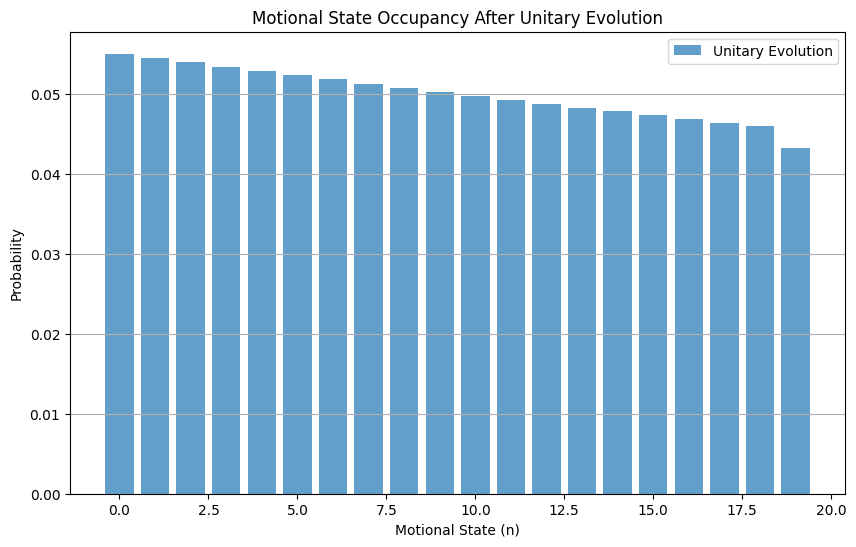

In [67]:
# Time evolution using the unitary operator of the Hamiltonian
U = (-1j * H * T_pulse).expm()  # Unitary operator for time evolution
state_evolved = U * initial_state * U.dag()

# Extract probabilities after unitary evolution
p_g_unitary = expect(tensor(basis(2, 1) * basis(2, 1).dag(), qeye(N)), state_evolved)
p_e_unitary = expect(tensor(basis(2, 0) * basis(2, 0).dag(), qeye(N)), state_evolved)
p_motional_unitary = np.zeros(N)
for n in range(N):
    motional_proj = tensor(qeye(2), basis(N, n) * basis(N, n).dag())
    p_motional_unitary[n] = expect(motional_proj, state_evolved)

# Plot results for unitary evolution
plt.figure(figsize=(10, 6))
plt.bar(np.arange(N), p_motional_unitary, alpha=0.7, label='Unitary Evolution')
plt.xlabel('Motional State (n)')
plt.ylabel('Probability')
plt.title('Motional State Occupancy After Unitary Evolution')
plt.legend()
plt.grid(axis='y')
plt.show()

In [ ]:
# Time evolution using the unitary operator of the Hamiltonian
U_pulse = (-1j * H * T_pulse).expm()  # Unitary operator for the pulse sequence
state_evolved = U_pulse * initial_state * U_pulse.dag()

# Extract probabilities after unitary evolution
p_g_unitary = expect(tensor(basis(2, 1) * basis(2, 1).dag(), qeye(N)), state_evolved)
p_e_unitary = expect(tensor(basis(2, 0) * basis(2, 0).dag(), qeye(N)), state_evolved)
p_motional_unitary = np.zeros(N)
for n in range(N):
    motional_proj = tensor(qeye(2), basis(N, n) * basis(N, n).dag())
    p_motional_unitary[n] = expect(motional_proj, state_evolved)

# Plot results for unitary evolution
plt.figure(figsize=(10, 6))
plt.bar(np.arange(N), p_motional_unitary, alpha=0.7, label='Unitary Evolution')
plt.xlabel('Motional State (n)')
plt.ylabel('Probability')
plt.title('Motional State Occupancy After Unitary Evolution')
plt.legend()
plt.grid(axis='y')
plt.show()